# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Предыдущая часть: https://github.com/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_7_72SHAP.ipynb

-Work in progress (last updated:10/06/2023)-

B. Цель данного блокнота

Целью этого блокнота является расчёт ROC и AUC для имеющихся моделей

C. План реализации

1. Импортировать табличные данные разметки классов по CAS и табличные данные уже обработанных спектров нужного диапазона.
2. Создать объект класса Dataset
3. Реализовать код расчёта ROC и AUC
4. Расчитать значения для всех моделей.


NOTES
1. Импортированы табличные данные.
2. Написана несколько версий модели. 
3.
6. 

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [1]:
!git clone https://github.com/Lamblador/IR_expert_system.git

Cloning into 'IR_expert_system'...
remote: Enumerating objects: 17004, done.
remote: Counting objects: 100% (2161/2161), done.
remote: Compressing objects: 100% (2010/2010), done.
remote: Total 17004 (delta 163), reused 2139 (delta 147), pack-reused 14843
Receiving objects: 100% (17004/17004), 1.47 GiB | 26.37 MiB/s, done.
Resolving deltas: 100% (523/523), done.
Updating files: 100% (16741/16741), done.


In [2]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install torchmetrics
!pip install peakutils
clear_output()

In [3]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
from peakutils.peak import indexes as index_utils

In [4]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

# Импорт табличных данных

In [5]:
#Считывание датасета
def read_dataset(dataset_name):
  '''
  Function for reading dataset into pandas Dataframe from /IR_expert_system/data/datasets/

  dataset_name - name of dataset's folder to read

  return pd.Dataframe with whole dataset

  parameters:
      name = ['dataset3']
          dataset3 - dataset made from reading most of jcam files, with padded y, interpolated x and peak layer. Saved in 10 pieces. 
  '''
  df_list = []
  # choose current directory
  curr_directory = os.getcwd()
  os.chdir(curr_directory)  # set to current directory
  files = glob.glob('/content/IR_expert_system/data/datasets/'+dataset_name+'/*.pkl')  # look for files without extension. Returns a list.
  # Try to read the file. If can't be read, skip it.
  #print(files)
  for i, file in tqdm(enumerate(files)):
      df = pd.read_pickle(file)
      df_list.append(df)
  #print(df_list)
  result = pd.concat(df_list)
  return result

dataset_df_readed = read_dataset('dataset3')
dataset_df_readed

10it [00:02,  3.93it/s]


,index,title,jcamp-dx,data type,origin,owner,molform,$nist source,spectrometer/data system,state,...,number of interferograms averaged per single channel spectrum,sample description,temperature,$spectra version,$uncertainty in y,pressure,x1,y1,y_peak,x_peak
cas registry no,,,,,,,,,,,,,,,,,,,,,
7496-45-9,7496-45-9,"Purine, 1-ethyl-",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,C7 H8 N4,COBLENTZ,PERKIN-ELMER 221 (GRATING),SOLID (0.8 mg / 650 mg KBr DISC),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13739997148513794, 0.13739997148513794, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[580, 640, 664, 726, 798, 834, 928, 966, 1022,..."
106-36-5,106-36-5,"Propanoic acid, propyl ester",4.24,INFRARED SPECTRUM,Sadtler Research Labs Under US-EPA Contract,NIST Standard Reference Data Program\nCollecti...,C 6 H 12 O 2,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.05554400011897087, 0.054496001452207565, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[542, 594, 618, 642, 674, 770, 814, 838, 882, ..."
5347-82-0,5347-82-0,DIMETHANE SULFONAMIDE,4.24,INFRARED SPECTRUM,"WYANDOTTE CHEMICALS CORP., WYANDOTTE, MICHIGAN...",COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,C2 H7 N O4 S2,COBLENTZ,"Not specified, most likely a prism, grating, o...",SOLID (MULL),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.21799999475479126, 0.21799999475479126, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[632, 662, 766, 866, 974, 1024, 1066, 1150, 13..."
112-17-4,112-17-4,1-Decanol acetate,4.24,INFRARED SPECTRUM,NIST Mass Spectrometry Data Center,NIST Standard Reference Data Program\nCollecti...,C 12 H 24 O 2,MSDC-IR,HP-GC/MS/IRD,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0001320000010309741, 0.0001320000010309741,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1042, 1234, 1370, 1462, 1762, 2866, 2934]"
4919-37-3,4919-37-3,"4-Hydroxy-3,5-dimethylbenzoic acid",4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 9 H 10 O 3,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.01228999998420477, 0.01228999998420477, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[588, 656, 770, 934, 1104, 1146, 1198, 1266, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173-72-2,25173-72-2,"3-(3,4,5-Trimethoxyphenyl)propionic acid",4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 12 H 16 O 5,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.010820000432431698, 0.010820000432431698, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[576, 778, 832, 930, 1016, 1044, 1118, 1186, 1..."
56946-83-9,56946-83-9,"2,5-Dichlorothiophene-3-sulphonyl chloride",4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 4 H Cl 3 O 2 S 2,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13794000446796417, 0.13794000446796417, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[558, 598, 632, 830, 854, 1008, 1046, 1136, 11..."
823-09-6,823-09-6,"Pyrimidine, 2-(methylthio)-,",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,C5 H6 N2 S,COBLENTZ,PERKIN-ELMER 21 (GRATING),LIQUID (NEAT),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.2558000087738037, 0.2558000087738037, 0.255...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[610, 710, 748, 770, 796, 876, 964, 1012, 1062..."


In [ ]:
labels_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
labels_df = labels_df.set_index("CAS")
#labels_df

In [141]:
labels72_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_list_with_72_bonds.csv')
labels72_df = labels72_df.set_index(["CAS"])
labels72_df

,Unnamed: 0,Name,Formula,Mw,Elements,InChi,SMILES,C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong,C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong,C─H alkyl methine 2890 weak,...,C─X fluoroalkanes ordinary 1000–1100,"C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands",C─X chloroalkanes any 540–760 weak to medium,C─X bromoalkanes any 500–600 medium to strong,C─X iodoalkanes any 500 medium to strong,N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker,N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated,P─C Organophosphorus compound aromatic 1440-1460 medium,P─O phosphorus oxide bonded 1195-1250 strong,P─O phosphorus oxide free 1250-1300 strong
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,0,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100-01-6,1,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100-02-7,2,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000-49-3,5,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000-50-6,6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,44445,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-78-0,44446,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-81-5,44448,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
dataset_df_labeled = labels_df.join(dataset_df_readed)
#dataset_df_labeled

In [142]:
dataset72_df_labeled = labels72_df.join(dataset_df_readed)

In [9]:
dataset_df_labeled1 = dataset_df_labeled[['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro',
       'title',
       'molform',
       'x', 'y', 'x1', 'y1', 'y_peak']]
#dataset_df_labeled1

In [145]:
dataset72_df_labeled1 = dataset72_df_labeled[[
 'Name',
 #'Formula',
 #'Mw',
 #'Elements',
 'InChi',
 #'SMILES',
 'C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong',
 'C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong',
 'C─H alkyl methine 2890 weak',
 'C─H vinyl C═CH2 900 strong/2975 medium/3080 medium',
 'C─H vinyl C═CH 3020 medium',
 'C─H vinyl monosubstituted alkenes 900 strong/990 strong',
 'C─H vinyl cis-disubstituted alkenes 670–700 strong',
 'C─H vinyl trans-disubstituted alkenes 965 strong',
 'C─H vinyl trisubstituted alkenes 800–840 strong to medium',
 'C─H aromatic benzene/sub. benzene 3070 weak',
 'C─H aromatic monosubstituted benzene 700–750 strong',
 'C─H aromatic monosubstituted benzene 690–710 strong',
 'C─H aromatic ortho-disub. benzene 750 strong',
 'C─H aromatic meta-disub. benzene 750–800 strong',
 'C─H aromatic meta-disub. benzene 860–900 strong',
 'C─H aromatic para-disub. benzene 800–860 strong',
 'C─H alkynes any 3300 medium',
 'C─H aldehydes any 2720 medium',
 'C─H aldehydes any 2820 medium',
 'C═C acyclic C═C monosub. alkenes 1645 medium',
 'C═C acyclic C═C 1,1-disub. alkenes 1655 medium',
 'C═C acyclic C═C cis-1,2-disub. alkenes 1660 medium',
 'C═C acyclic C═C trans-1,2-disub. alkenes 1675 medium',
 'C═C acyclic C═C trisub., tetrasub. alkenes 1670 weak',
 'C═C conjugated C═C dienes 1600 strong/1650 strong',
 'C═C with benzene ring dienes 1625 strong',
 'C═C with C═O dienes 1600 strong',
 'C═C C═C (both sp2) any 1640–1680 medium',
 'C═C aromatic C═C any 1450/1500/1580/1600 weak to strong (usually 3 or 4)',
 'C═C C≡C terminal alkynes 2100–2140 weak',
 'C═C C≡C disubst. alkynes 2190–2260 very weak (often indistinguishable)',
 'C=O aldehyde/ketone saturated aliph./cyclic 6-membered 1720 ',
 'C=O aldehyde/ketone α,β-unsaturated 1685 ',
 'C=O aldehyde/ketone aromatic ketones 1685 ',
 'C=O aldehyde/ketone aldehydes 1725 influenced by conjugation (as with ketones)',
 'C=O carboxylic acids/derivates saturated carboxylic acids 1710 ',
 'C=O carboxylic acids/derivates unsat./aromatic carb. acids 1680–1690 ',
 'C=O carboxylic acids/derivates esters and lactones 1735 influenced by conjugation and ring size (as with ketones)',
 'C=O carboxylic acids/derivates anhydrides 1760 ',
 'C=O carboxylic acids/derivates anhydrides 1820 ',
 'C=O carboxylic acids/derivates acyl halides 1800 ',
 'C=O carboxylic acids/derivates amides 1650 associated amides',
 'C=O carboxylic acids/derivates amino acid zwitterions 1550–1610 ',
 'O─H alcohols, phenols low concentration 3610–3670/high concentration 3200–3400 broad',
 'O─H carboxylic acids low concentration 3500–3560/high concentration 3000 broad',
 'N─H primary amines any 3400–3500 strong/1560–1640 strong',
 'N─H secondary amines any > 3000 weak to medium',
 'N─H ammonium ions any 2400–3200 multiple broad peaks',
 'C─O alcohols primary 1040–1060 strong, broad',
 'C─O alcohols secondary ~ 1100 strong',
 'C─O alcohols tertiary 1150–1200 medium',
 'C─O phenols any 1200',
 'C─O ethers aliphatic 1120',
 'C─O ethers aromatic 1220–1260',
 'C─O carboxylic acids any 1250–1300',
 'C─O esters any 1100–1300 two bands (distinct from ketones, which do not possess a C─O bond)',
 'C─N aliphatic amines any 1020–1220 often overlapped',
 'C─N C═N any 1615–1700 similar conjugation effects to C═O',
 'C─N C≡N (nitriles) unconjugated 2250 medium',
 'C─N C≡N (nitriles) conjugated 2230 medium',
 'C─N R─N─C (isocyanides) any 2165–2110',
 'C─N R─N═C═S (isothiocyanates) any 2140–1990',
 'C─X fluoroalkanes ordinary 1000–1100',
 'C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands',
 'C─X chloroalkanes any 540–760 weak to medium',
 'C─X bromoalkanes any 500–600 medium to strong',
 'C─X iodoalkanes any 500 medium to strong',
 'N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker',
 'N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated',
 'P─C Organophosphorus compound aromatic 1440-1460 medium',
 'P─O phosphorus oxide bonded 1195-1250 strong',
 'P─O phosphorus oxide free 1250-1300 strong',
#  'index',
#  'title',
#  'jcamp-dx',
#  'data type',
#  'class',
#  'origin',
#  'owner',
#  'date',
#  'names',
#  'molform',
#  'source reference',
#  '$nist source',
#  '$nist image',
#  'spectrometer/data system',
#  'path length',
#  'sampling procedure',
#  'resolution',
#  'data processing',
#  'xunits',
#  'yunits',
#  'xfactor',
#  'yfactor',
#  'deltax',
#  'firstx',
#  'lastx',
#  'firsty',
#  'maxx',
#  'minx',
#  'maxy',
#  'miny',
#  'npoints',
#  'xydata',
#  'end',
 'x',
 'y',
#  'filename',
#  'state',
#  'instrument parameters',
#  'xlabel',
#  'ylabel',
#  'mp',
#  'bp',
#  '$nist doc file',
#  '$nist psd file',
#  'aperture',
#  'external diffuse reflectance accessory',
#  'beamsplitter',
#  'detector (dia. det. port in sphere)',
#  'sphere diameter',
#  'acquisition mode',
#  'scanner speed',
#  'coadded scans',
#  'phase resolution',
#  'phase correction',
#  'zerofilling',
#  'spectral range',
#  'spectral resolution',
#  'wavenumber accuracy',
#  'apodization function',
#  'low pass filter',
#  'switch gain on',
#'cas name',
#  'instrument resolution',
#  'ir source',
#  'detector',
#  'interferogram zerofill',
#  'spectral interval after zerofilling',
#  'apodization',
#  'folding limits',
#  'number of interferograms averaged per single channel spectrum',
#  '$spectra version',
#  '$uncertainty in y',
#  'sample description',
#  'pressure',
#  'temperature',
 'x1',
 'y1',
 'y_peak',
 'x_peak']]

#Добавление слоёв со всеми положениями максимумов для классов

С "https://en.wikipedia.org/wiki/Infrared_spectroscopy_correlation_table" и Koshelev_IR_expert_system_5_72kNN_ML (https://colab.research.google.com/drive/1DcntOKEOec_MPN_CIZywpjZuo2OjTAGm#scrollTo=_PmXuJTkRr07)

In [14]:
all_keys_list_short = ['C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong',
 'C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong',
 'C─H alkyl methine 2890 weak',
 'C─H vinyl C═CH2 900 strong/2975 medium/3080 medium',
 'C─H vinyl C═CH 3020 medium',
 'C─H vinyl monosubstituted alkenes 900 strong/990 strong',
 'C─H vinyl cis-disubstituted alkenes 670–700 strong',
 'C─H vinyl trans-disubstituted alkenes 965 strong',
 'C─H vinyl trisubstituted alkenes 800–840 strong to medium',
 'C─H aromatic benzene/sub. benzene 3070 weak',
 'C─H aromatic monosubstituted benzene 700–750 strong',
 'C─H aromatic monosubstituted benzene 690–710 strong',
 'C─H aromatic ortho-disub. benzene 750 strong',
 'C─H aromatic meta-disub. benzene 750–800 strong',
 'C─H aromatic meta-disub. benzene 860–900 strong',
 'C─H aromatic para-disub. benzene 800–860 strong',
 'C─H alkynes any 3300 medium',
 'C─H aldehydes any 2720 medium',
 'C─H aldehydes any 2820 medium',
 'C═C acyclic C═C monosub. alkenes 1645 medium',
 'C═C acyclic C═C 1,1-disub. alkenes 1655 medium',
 'C═C acyclic C═C cis-1,2-disub. alkenes 1660 medium',
 'C═C acyclic C═C trans-1,2-disub. alkenes 1675 medium',
 'C═C acyclic C═C trisub., tetrasub. alkenes 1670 weak',
 'C═C conjugated C═C dienes 1600 strong/1650 strong',
 'C═C with benzene ring dienes 1625 strong',
 'C═C with C═O dienes 1600 strong',
 'C═C C═C (both sp2) any 1640–1680 medium',
 'C═C aromatic C═C any 1450/1500/1580/1600 weak to strong (usually 3 or 4)',
 'C═C C≡C terminal alkynes 2100–2140 weak',
 'C═C C≡C disubst. alkynes 2190–2260 very weak (often indistinguishable)',
 'C=O aldehyde/ketone saturated aliph./cyclic 6-membered 1720 ',
 'C=O aldehyde/ketone α,β-unsaturated 1685 ',
 'C=O aldehyde/ketone aromatic ketones 1685 ',
 'C=O aldehyde/ketone aldehydes 1725 influenced by conjugation (as with ketones)',
 'C=O carboxylic acids/derivates saturated carboxylic acids 1710 ',
 'C=O carboxylic acids/derivates unsat./aromatic carb. acids 1680–1690 ',
 'C=O carboxylic acids/derivates esters and lactones 1735 influenced by conjugation and ring size (as with ketones)',
 'C=O carboxylic acids/derivates anhydrides 1760 ',
 'C=O carboxylic acids/derivates anhydrides 1820 ',
 'C=O carboxylic acids/derivates acyl halides 1800 ',
 'C=O carboxylic acids/derivates amides 1650 associated amides',
 'C=O carboxylic acids/derivates amino acid zwitterions 1550–1610 ',
 'O─H alcohols, phenols low concentration 3610–3670/high concentration 3200–3400 broad',
 'O─H carboxylic acids low concentration 3500–3560/high concentration 3000 broad',
 'N─H primary amines any 3400–3500 strong/1560–1640 strong',
 'N─H secondary amines any > 3000 weak to medium',
 'N─H ammonium ions any 2400–3200 multiple broad peaks',
 'C─O alcohols primary 1040–1060 strong, broad',
 'C─O alcohols secondary ~ 1100 strong',
 'C─O alcohols tertiary 1150–1200 medium',
 'C─O phenols any 1200',
 'C─O ethers aliphatic 1120',
 'C─O ethers aromatic 1220–1260',
 'C─O carboxylic acids any 1250–1300',
 'C─O esters any 1100–1300 two bands (distinct from ketones, which do not possess a C─O bond)',
 'C─N aliphatic amines any 1020–1220 often overlapped',
 'C─N C═N any 1615–1700 similar conjugation effects to C═O',
 'C─N C≡N (nitriles) unconjugated 2250 medium',
 'C─N C≡N (nitriles) conjugated 2230 medium',
 'C─N R─N─C (isocyanides) any 2165–2110',
 'C─N R─N═C═S (isothiocyanates) any 2140–1990',
 'C─X fluoroalkanes ordinary 1000–1100',
 'C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands',
 'C─X chloroalkanes any 540–760 weak to medium',
 'C─X bromoalkanes any 500–600 medium to strong',
 'C─X iodoalkanes any 500 medium to strong',
 'N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker',
 'N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated',
 'P─C Organophosphorus compound aromatic 1440-1460 medium',
 'P─O phosphorus oxide bonded 1195-1250 strong',
 'P─O phosphorus oxide free 1250-1300 strong']

In [15]:
#Составляем словарь {класс: {волновое число проявления:сила проявления из key_worlds = ['strong', 'medium', 'weak']}}
#Возможность для улучшения
key_worlds = ['weak to strong',  'medium to strong', 'weak', 'medium','strong']
import re
all_band_dic = {}
for key in all_keys_list_short[-2:-1]:
  band_dic = {}
  #поиск в строке диапазонов значений формата 300-300
  r = '\d+-\d+' #Поиск диапазонов
  diap = re.findall(r, key)
  #поиск в строке значений формата 300
  r2 = '\d+' #Поиск отдельных чисел
  solos = re.findall(r2, key)
  #Проверка на повторение
  print('1', diap, solos)
  for num_solo in solos:
    print('1.1', num_solo)
    if int(num_solo) <=10: 
        solos.remove(num_solo)
        continue
    print('1.2', solos)   
  for num_diap in diap:
      if str(num_solo) in str(num_diap): 
        solos.remove(num_solo)
      print('1.3', solos)
        
      
  print('2', diap, solos)
  all_nums = diap+solos
  print(all_nums)
  #поиск и сохранение ключевых слов, удаление из строки названия уже найденых
  class_keys = []
  for key_world in key_worlds:
      class_key = key
      if key_world in class_key: 
        class_keys.append(key_world)
        class_key.replace(key_world, '')
  #Составление словаря для класса
  #print(all_nums, class_keys)
  for i, num in enumerate(all_nums):
    try:
        band_dic[num] = class_keys[i]
    except IndexError: #Есть ключевого слова нет - ставим среднее значение
        band_dic[num] = 'medium'
  all_band_dic[key] = band_dic
print(all_band_dic)
print(len(all_band_dic))

1 ['1195-1250'] ['1195', '1250']
1.1 1195
1.2 ['1195', '1250']
1.1 1250
1.2 ['1195', '1250']
1.3 ['1195']
2 ['1195-1250'] ['1195']
['1195-1250', '1195']
{'P─O phosphorus oxide bonded 1195-1250 strong': {'1195-1250': 'strong', '1195': 'medium'}}
1


In [16]:
#Список полос колебаний
all_num_list = [
[1260,1380,2870,2960],
[1470,2850,2925],
[2890],
[2900,2975,3080],
[3020],
[900,990],
[670,700],
[965],
[800,840],
[3070],
[700,750],
[690,710],
[750],
[750,800],
[860,900],
[800,860],
[3300],
[2720],
[2820],
[1645],
[1655],
[1660],
[1675],
[1670],
[1600,1650],
[1625],
[1600],
[1640,1680],
[1450,1500,1580,1600],
[2100,2140],
[2190,2260],
[1720],
[1685],
[1685],
[1725],
[1710],
[1680,1690],
[1735],
[1760],
[1820],
[1800],
[1650],
[1550,1610],
[3610,3670, 3200,3400],
[3500,3560, 3000],
[3400,3500, 1560,1640],
[3000],
[2400,3200],
[1040,1060],
[1100],
[1150,1200],
[1200],
[1120],
[1220,1260],
[1250,1300],
[1100,1300],
[1020,1220],
[1615,1700],
[2250],
[2230],
[2165,2110],
[2140,1990],
[1000,1100],
[1100,1200],
[540,760],
[500,600],
[500],
[1540,1380],
[1520,1350],
[1440,1460],
[1195,1250],
[1250,1300],
]

In [17]:
#Проверка чётности полосы
for i, num_list in enumerate(all_num_list):
  for j, num in enumerate(num_list):
    if num%2 == 1: all_num_list[i][j]=all_num_list[i][j]+1
#all_num_list

In [18]:
dataset_df_labeled1.iloc[:,-3][0]

array([ 500,  502,  504, ..., 4094, 4096, 4098])

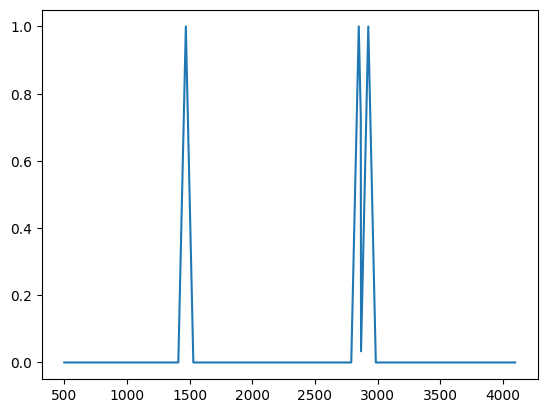

In [19]:
#Создаём дополнительный слой для каждого класса для входа в сеть, где +/- вокруг предполагаемого положения будет от 0 до 1, а вне - 0.
def print_peak_neighborhood(peak_indx, x, num_neighbors = 10):
  '''
  Cover neighbor of the class peak position with numbers between 0 and 1

  parameters:
  peak_indx - list of even wavenumber (1/cm) of peak possible position
  x - array like object of wavenumbers in spectra
  num_neighbors - nuber of neighbors which should be changed. Means the area of intrest of NN.
  '''
  class_peak_indx_list = []
  for num in peak_indx:
      try:
        y_mask_4_class = np.zeros(len(x))
        class_peak_indx_list.append(list(x).index(num))
      except TypeError:
        y_mask_4_class = np.zeros(1800)
        continue
  for i in class_peak_indx_list:
      for k in range(num_neighbors):
          y_mask_4_class[i-k] = 1-(1/num_neighbors)*k
          y_mask_4_class[i+k] = 1-(1/num_neighbors)*k
  return y_mask_4_class
#Проверка работоспособности
plt.plot(dataset_df_labeled1.iloc[:,-3][1], print_peak_neighborhood(all_num_list[1], dataset_df_labeled1.iloc[:,-3][1], num_neighbors = 30))

In [20]:
#Создаём дополнительный слой для каждого класса для входа в сеть, где +/- вокруг предполагаемого положения будет от 0 до 1, а вне - 0.
df_cls_attention = []
for i, num_list in enumerate(all_num_list):
  class_attention = print_peak_neighborhood(all_num_list[i], dataset_df_labeled1.iloc[:,-3][i], num_neighbors = 30)
  df_cls_attention.append(torch.Tensor(class_attention))
print(df_cls_attention)
df_cls_attention = torch.stack(df_cls_attention, dim=1).reshape((1800,72))
df_cls_attention.size()

[tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]),

torch.Size([1800, 72])

In [21]:
#Схлопываем все слои в один
df_cls_attention = torch.sum(df_cls_attention, dim=1)

In [22]:
#нормирование слоя на 1
df_cls_attention = df_cls_attention/max(df_cls_attention)

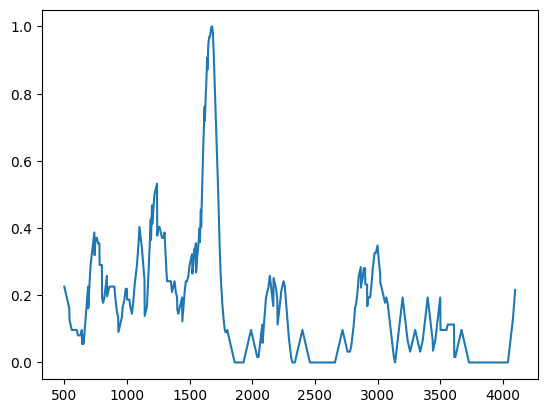

In [23]:
plt.plot(dataset_df_labeled1.iloc[:,-3][1], df_cls_attention)

# Создание класса Dataset

In [119]:
#Класс датасета на 17 классов со входом формата (2,1800)
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800))      
        spectra = torch.cat((spectra_x, spectra_y))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [120]:
#Класс датасета на 17 классов со входом формата (3,1800) +вход максимумов
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDatasetP(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        self.spectra_y_peak = self.dataset_df.iloc[:,-1]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800)) 
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))     
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [149]:
#Класс датасета на 17 классов со входом формата (4,1800)+вход максимумов+вход положений полос
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDatasetPA(Dataset):
    def __init__(self, dataset_df_labeled, df_cls_attention):
        self.dataset_df = dataset_df_labeled
        self.df_cls_attention = df_cls_attention
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        self.spectra_y_peak = self.dataset_df.iloc[:,-1]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800)) 
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))
        class_attention = torch.Tensor(self.df_cls_attention).reshape((1, 1800))
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak, class_attention))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [157]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset72(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,2:-6]
        self.spectra_x = self.dataset_df.iloc[:,-4]
        self.spectra_y = self.dataset_df.iloc[:,-3]
        self.spectra_y_peak = self.dataset_df.iloc[:,-2]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800)) 
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))     
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [295]:
#Создание объекта класса и разбиение на трейн,тест и вал в соотношении 7/2/1
from torch.utils.data import random_split
dataset_ir_spectra = IRSpectraDatasetPA(dataset_df_labeled1.dropna(), df_cls_attention) #, df_cls_attention for v0.6
train_size = int(0.7 * len(dataset_ir_spectra))
val_size = int(0.1 * len(dataset_ir_spectra))
test_size = len(dataset_ir_spectra) - train_size - val_size
train_dataset, test_dataset = random_split(dataset_ir_spectra, [train_size, int(test_size+val_size)])
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [296]:
# расчёт количества классов
classes = list(dataset_ir_spectra.spectra_labels.columns)
num_classes = len(classes)
num_classes

17

In [297]:
#Создание словарей перевода класса в индексы и обратно
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
print(cls2inx)
print(inx2cls)

{'alkane': 0, 'methyl': 1, 'alkene': 2, 'alkyne': 3, 'alcohols': 4, 'amines': 5, 'nitriles': 6, 'aromatics': 7, 'alkyl halides': 8, 'esters': 9, 'ketones': 10, 'aldehydes': 11, 'carboxylic acids': 12, 'ether': 13, 'acyl halides': 14, 'amides': 15, 'nitro': 16}
{0: 'alkane', 1: 'methyl', 2: 'alkene', 3: 'alkyne', 4: 'alcohols', 5: 'amines', 6: 'nitriles', 7: 'aromatics', 8: 'alkyl halides', 9: 'esters', 10: 'ketones', 11: 'aldehydes', 12: 'carboxylic acids', 13: 'ether', 14: 'acyl halides', 15: 'amides', 16: 'nitro'}


In [298]:
# Расчёт весов классов
wts4cls = {}
for classs in classes:
  wts4cls[classs] = dataset_ir_spectra.spectra_labels[classs].mean()
print(wts4cls)

{'alkane': 0.6826801517067004, 'methyl': 0.6218289085545723, 'alkene': 0.13552465233881164, 'alkyne': 0.01955330804888327, 'alcohols': 0.21862621154656553, 'amines': 0.13080488832701223, 'nitriles': 0.038179519595448796, 'aromatics': 0.5845764854614413, 'alkyl halides': 0.2595027391487568, 'esters': 0.11639275179098188, 'ketones': 0.09405815423514538, 'aldehydes': 0.02064896755162242, 'carboxylic acids': 0.060345554150863887, 'ether': 0.250063211125158, 'acyl halides': 0.009608091024020228, 'amides': 0.07088074167720185, 'nitro': 0.05731142014327855}


In [299]:
#Веса классов
wts_list = []
for name, values in wts4cls.items():
  wts_list.append(values)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

tensor([0.6827, 0.6218, 0.1355, 0.0196, 0.2186, 0.1308, 0.0382, 0.5846, 0.2595,
        0.1164, 0.0941, 0.0206, 0.0603, 0.2501, 0.0096, 0.0709, 0.0573],
       dtype=torch.float64)


In [300]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weight_for_every_class, len(weight_for_every_class)) 

dataloader_ir_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler= weightedsampler
)

In [301]:
#  Проверка работоспособности
for i, j in dataloader_ir_train:
  print(i.shape, j.shape)
  break

torch.Size([17, 4, 1800]) torch.Size([17, 17])


# Модель

Предлагается использовать модель с несколькими свёрточными слоями(1) и понижением размерности до 225-450, а затем с полносвязыными слоями, где на выходе одни слой из 17 меток классов.

Базовая модель: 8 сверток посчитать обучаемых параметров и потом собирать статистику.
классификейшон репорт
Потом увеличить количество свёрточных слоёв до 12. 
Увеличивать количество каналов через 1 макспул.
Выводить лосс для теста.

## Базовая модель

In [32]:
from torch.nn.modules.pooling import MaxPool2d
import torch.nn as nn
import torch

class TwoLayerCNN(nn.Module):
    def __init__(self, hidden_size = 34):
        super().__init__()
        self.hidden_size=hidden_size
        self.bblock = nn.Sequential(
            nn.Conv1d(2, hidden_size, kernel_size = 3, padding = 1), # in channel=2, out=hidden_size 3 - ядро свертки, таблица 1800 точек*2 столбца
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,1800] -> [hidden_size,900] 

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,900] -> [hidden_size,450] 
            
            nn.Conv1d(hidden_size, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,450] -> [hidden_size,225] 

            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(225*2*hidden_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 17),
            nn.Sigmoid()
            )

    def forward(self, x):
        # Your code here
        x = self.bblock(x) 
        return x

## v0.3.0 - модель с res-связями и 2 dropout. 

In [33]:
#Возможно тестирование увеличения глубины
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet3(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet3, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=3, stride=1, padding = 1) #[2,1800]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        # self.layer2 = nn.Sequential(
        #     BasicBlock(hidden_size, downsample = False), #[2,1800]
        #     BasicBlock(hidden_size),
        #     BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        # self.layer4 = nn.Sequential(
        #     BasicBlock(hidden_size*2, downsample = False), 
        #     BasicBlock(hidden_size*2),
        #     BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        # self.layer6 = nn.Sequential(
        #     BasicBlock(hidden_size*4, downsample = False), 
        #     BasicBlock(hidden_size*4),
        #     BasicBlock(hidden_size*4))
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        # self.layer8 = nn.Sequential(
        #     BasicBlock(hidden_size*8, downsample = False), #[2,225]
        #     BasicBlock(hidden_size*8),
        #     BasicBlock(hidden_size*8))
        self.adppool = nn.AdaptiveMaxPool1d(225)
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*225, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        #self.sm = nn.Sigmoid()
        


    def forward(self, batch):
      # PUT YOUR CODE HERE
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        #batch = self.layer2(batch)
        batch = self.layer3(batch)
        #batch = self.layer4(batch)
        batch = self.layer5(batch)
        #batch = self.layer6(batch)
        batch = self.layer7(batch)
        #batch = self.layer8(batch)
        batch = self.adppool(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)
        
        #scores=self.sm(batch)
              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out
        

## v0.4.0 - добавление к 0.3.0 макспулов для уменьшения количества параметров.

In [34]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet4(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet4, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=5, stride=2, padding = 1) #[2,1800]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.max1 = nn.MaxPool1d(3,2,0)
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.max2 = nn.MaxPool1d(3,2,0)
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        #self.adppool = nn.AdaptiveMaxPool1d(14)
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*14, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        


    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.max1(batch)
        batch = self.layer3(batch)
        batch = self.max2(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)
              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out
        

## v0.5.0 На вход добавлен слой с положением пиков [3, 1800].
v0.5.0 - аналог v0.4.0 но вход [3,1800]
v0.5.1 - убраны два макспула

In [231]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet5_0(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet5_0, self).__init__()
        self.hidden_size=hidden_size
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.max1 = nn.MaxPool1d(3,2,0)
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.max2 = nn.MaxPool1d(3,2,0)
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*14, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        


    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.max1(batch)
        batch = self.layer3(batch)
        batch = self.max2(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)
        
        #scores=self.sm(batch)
              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

In [35]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet5(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet5, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        


    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer3(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

## v0.6.0 добавление внимания

Здесь будет добавлены несколько слоёв внимания, которые будут дополнять линейный слой.

По сравнению с IrNet4 убран второй дроп-аут, переделана голова. Сxема работы - 2 слоя внимания получают выходы с 3го и 5го ResNet-блока. Выходы со слоя внимания добавляются к линейному слою перед подачей на выравнивающий слой. Слои внимания выдяются отдельно.

In [36]:
class AttentionBlock1d(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock1d, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv1d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv1d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv1d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, H = l.size() #[2,20,450]
        l_ = self.W_l(l)
        #print('l')
        #print(l.size())
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='linear', align_corners=True)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xH
        #print(c.size()) #[2,1,450]
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        #print(a.size()) #[2,1,450]
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxH
        #print(f.size()) #[2,20,450]
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=1) # weighted sum
        else:
            output = F.adaptive_avg_pool1d(f, 1).view(N,C) # global average pooling
       # print('output')
       # print(output.size()) #[2,20]
        #print('a')
        #print(a.size()) #[2,1,450]
        return a, output

In [37]:
#В модель v0.5 добавлены два слоя внимания с выводом результата в линейный слой
#При выводе из модели не только результатов, но еще чего-то ломается функция summary
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet6(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17, normalize_attn=False, dropout=None):
        super(IrResnet6, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[hidden_size,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
                
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[hidden_size,899]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[hidden_size*2,450]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[hidden_size*4,225]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)                   #[hidden_size*4,112]
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[hidden_size*8,56]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.dpt = None
        if dropout is not None:
            self.dpt1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size*8*56+450+225, 200)
        if dropout is not None:
            self.dpt2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(200, class_nums)
        
        # initialize the attention blocks defined above
        self.attn1 = AttentionBlock1d(hidden_size*2, hidden_size*8, hidden_size*4, 8.05)
        self.attn2 = AttentionBlock1d(hidden_size*4, hidden_size*8, hidden_size*4, 4.03)
              
        self.reset_parameters(self.fc1)
        self.reset_parameters(self.fc2)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)

    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
        
    def forward(self, batch):
      
        batch_conv1 = self.conv1(batch)
        batch_norm1 = self.bn1(batch_conv1)
        batch_relu1 = self.relu(batch_norm1)
        batch_layer1 = self.layer1(batch_relu1)
        batch_layer2 = self.layer2(batch_layer1)
        batch_layer3 = self.layer3(batch_layer2)
        batch_max3 = self.max3(batch_layer3)
        batch_layer4 = self.layer4(batch_max3)
        batch_flatten = self.flatten(batch_layer4)    
        a1, g1 = self.attn1(batch_layer2, batch_layer4)
        a2, g2 = self.attn2(batch_layer3, batch_layer4)
        g_hat = torch.cat((batch_flatten,g1,g2), dim=1) # batch_size x C      
        if self.dpt is not None:
             g_hat = self.dpt1(g_hat)
        g_hat1 = self.fc1(g_hat)
        if self.dpt is not None:
             g_hat1 = self.dpt2(g_hat1)  
        scores = self.fc2(g_hat1)
        return scores, a1, a2



class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

##v0.7.0 добавление слоёв всех положений полос

На основе версии 5. Добавлены слои со всеми возможными положениями пиков

В версии v0.7.1 все слои внимания схлопнуты в 1 слой.

В версии v0.7.2 этот слой нормирован на 1.

In [38]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet7(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet7, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(4, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer2(batch)
        batch = self.layer3(batch)
        batch = self.max3(batch)
        batch = self.layer4(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)                    
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

Оптимизатор - Адам с базовыми настройками

Лосс - Бинарная кросс-энтропия

#Импорт модели

In [307]:
#Импорт модели из зоопарка
model = IrResnet5(50, class_nums = 17)
version = 'v0.5.1.50'
model.load_state_dict(torch.load('/content/IR_expert_system/models/'+version+'/'+version+'_model_param'))
#model.load_state_dict(torch.load('/content/IR_expert_system/models/v0.4.2.50/v.4.2.50_model_param'))
model.eval()

IrResnet7(
  (conv1): Conv1d(4, 50, kernel_size=(3,), stride=(2,), padding=(1,))
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicBlock(


#Оценка качества модели classification report

In [308]:
from sklearn.metrics import classification_report
def get_statistic(model, device, val_dataloader, tolerance = 0.5):
  '''
  Функция для получения статистики модели с мультиклассовой классификацией.

  parameters:
    model - torch.model, для которой считается статистика
    device - устройство для расчёта статистики (cuda/cpu)
    val_dataloader - даталоадер для валидации со спектрами, которых не было в обучающей выборке
    tolerance - float значение порога срабатывания модели (0.5)
  '''
  y_true = torch.Tensor()
  y_pred = torch.Tensor()
  model.eval()
  #Расчёт по тестовому даталоадеру предсказанных и реальных значений
  for data, label in val_dataloader:
    #out, _, _ = model.to(device)(data.to(device)) #версия 6
    out = model.to(device)(data.to(device))
    data.to('cpu')
    y_true = torch.cat((label.cpu().detach(), y_true), dim = 0)
    y_pred = torch.cat((out.cpu().detach(), y_pred), dim = 0)
  #print(y_true.size(), y_pred.size())
  #Приведение значений к бинарному виду для расчёта classification report при превышении порога tolerance
  for i in range(len(y_pred)):
    y_pred[i][y_pred[i]<tolerance]=0
    y_pred[i][y_pred[i]>=tolerance]=1
  model.to('cpu')
  return classification_report(y_true, y_pred, target_names = classes)


In [309]:
cr = get_statistic(model, 'cpu', dataloader_ir_val, tolerance = 0.5)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [310]:
print(cr)

                  precision    recall  f1-score   support

          alkane       0.64      0.01      0.02       834
          methyl       0.00      0.00      0.00       732
          alkene       0.00      0.00      0.00       150
          alkyne       0.00      0.00      0.00        21
        alcohols       0.00      0.00      0.00       251
          amines       0.00      0.00      0.00       168
        nitriles       0.00      0.00      0.00        42
       aromatics       0.59      0.97      0.74       705
   alkyl halides       0.00      0.00      0.00       306
          esters       0.00      0.00      0.00       142
         ketones       0.00      0.00      0.00       109
       aldehydes       0.00      0.00      0.00        16
carboxylic acids       0.00      0.00      0.00        58
           ether       0.00      0.00      0.00       307
    acyl halides       0.00      0.00      0.00         9
          amides       0.00      0.00      0.00       104
           ni

# Оценка качества модели AUC ROC

In [311]:
#Очистка памяти GPU
import gc
torch.cuda.empty_cache()
gc.collect()

18818

Расчёт ROCAUC

In [312]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
model.eval()
device = 'cpu'
# Evaluate the model on the validation set
probs = []
true_labels = []

with torch.no_grad():
    for images, labels in dataloader_ir_val:
        # Move images and labels to the device (e.g., GPU) if available
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        prob = torch.sigmoid(outputs)
        

        true_labels.extend(labels.numpy())
        probs.extend(prob.cpu().numpy())

probs = np.array(probs)
labels = np.array(true_labels) 

In [314]:
def calc_roc_auc_for_class(labels, probs):
  # Расчет кривой ROC-AUC
  fpr, tpr, thresholds = roc_curve(labels, probs)
  roc_auc = roc_auc_score(labels, probs)
  return fpr, tpr, thresholds, roc_auc

In [315]:
roc_auc_for_class = {}

for i in range(len(inx2cls)):
  fpr, tpr, thresholds, roc_auc = calc_roc_auc_for_class(labels.T[i], probs.T[i])
  roc_auc_for_class[inx2cls[i]]= {'fpr':fpr, 'tpr': tpr, 'thresholds':thresholds, 'roc_auc':roc_auc}
#print(roc_auc_for_class)

In [317]:
from google.colab import files
def plot_auc_for_class(roc_auc_for_one_class, class_name, model_version):
    plt.figure(figsize=(3, 3))
    fpr=roc_auc_for_one_class['fpr']
    tpr=roc_auc_for_one_class['tpr']
    roc_auc=roc_auc_for_one_class['roc_auc']
    # Вывод графика кривой ROC-AUC
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_version+'_'+class_name)
    class_name=class_name.replace('/', '_')
    plt.legend(loc="lower right")
    plt.savefig(model_version+'_'+class_name+'.png', dpi='figure', format='png', bbox_inches = 'tight', pad_inches=0.1)
    files.download(model_version+'_'+class_name+'.png')
    plt.show()

In [ ]:
model_version = version
for i in range(len(inx2cls)):
  print(inx2cls[i])
  plot_auc_for_class(roc_auc_for_class[inx2cls[i]], inx2cls[i], version)

In [319]:
#Вывод и сохранение данных auc_roc
roc = {}
for i in range(len(inx2cls)):
  #print(roc_auc_for_class[inx2cls[i]]['roc_auc'])
  roc[inx2cls[i]] = [roc_auc_for_class[inx2cls[i]]['roc_auc']]
df_roc = pd.DataFrame(roc)
df_roc.to_csv(version+'_roc_auc.csv')
files.download(version+'_roc_auc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Конец